In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from copy import deepcopy
from datetime import datetime as dt
from itertools import product
import math
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import RidgeCV, Ridge, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler

In [3]:
def rmse(predictions, actuals): 
    return math.sqrt(((predictions - actuals)**2).mean())

def print_score(m):
    print('RMSE for training:   ', rmse(m.predict(X_train), y_train))
    print('RMSE for validation: ', rmse(m.predict(X_valid), y_valid))
    print('R^2 for training:    ', m.score(X_train, y_train))
    print('R^2 for validation:  ', m.score(X_valid, y_valid))
    if hasattr(m, 'oob_score_'): 
        print('OoB score:           ', m.oob_score_)

def split_vals(a,n): 
    return a[:n].copy(), a[n:].copy()

In [65]:
housing = pd.read_csv('train.csv')

In [66]:
housing['SalePrice'] = np.log(housing.SalePrice)

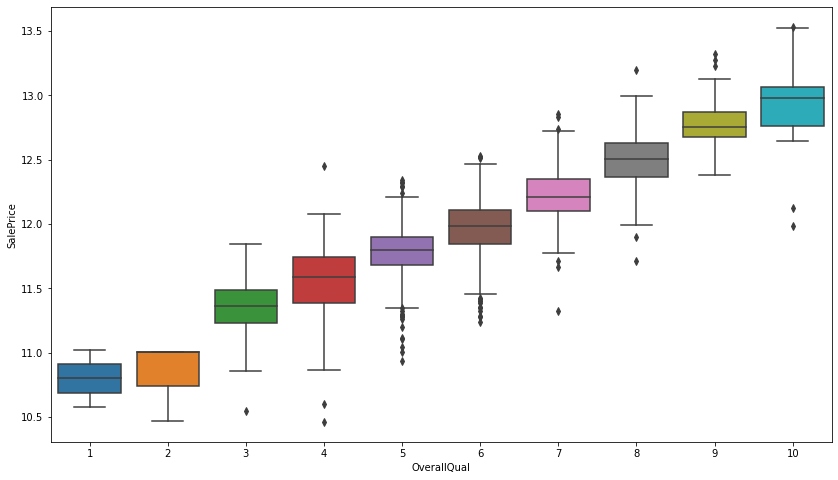

In [67]:
plt.figure(figsize=(14, 8))
sns.boxplot(x = housing['OverallQual'], y = housing['SalePrice'])

In [68]:
housing.groupby('OverallQual').agg('median')['SalePrice']

OverallQual
1     10.798804
2     11.002100
3     11.364900
4     11.589887
5     11.798104
6     11.982929
7     12.206777
8     12.505250
9     12.751300
10    12.976974
Name: SalePrice, dtype: float64

In [69]:
overall_qual_group = housing.groupby('OverallQual')['SalePrice']

In [70]:
# Quantile 1 = 25% of data
Q1 = overall_qual_group.quantile(.25)
Q3 = overall_qual_group.quantile(.75)

In [71]:
# IQR = Interquartile Range
IQR = Q3 - Q1

# Limits
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

In [72]:
# DataFrame to store the new data
new_data = pd.DataFrame()

for rating in overall_qual_group.groups.keys():
    is_rating = housing['OverallQual'] == rating
    accepted_limit = ((housing['SalePrice'] >= lower[rating]) &
                     (housing['SalePrice'] <= upper[rating]))
    
    select = is_rating & accepted_limit
    data_select = housing[select]
    new_data = pd.concat([new_data, data_select])

In [73]:
print(len(housing),len(new_data))

1460 1408


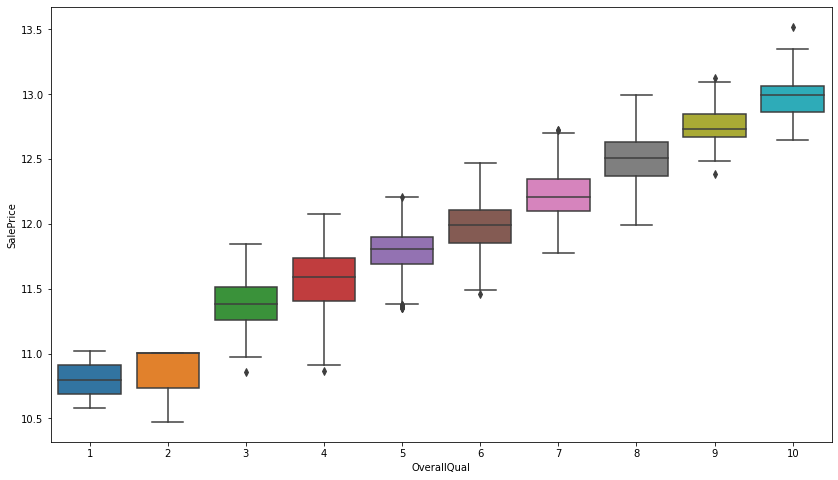

In [74]:
plt.figure(figsize=(14, 8))
sns.boxplot(x = new_data['OverallQual'], y= new_data['SalePrice'])

In [75]:
new_data.groupby('ExterQual').agg('median')['SalePrice']
exter_qual_group = new_data.groupby('ExterQual')['SalePrice']

# Quantile 1 = 25% of data
Q1 = exter_qual_group.quantile(.2)
Q3 = exter_qual_group.quantile(.8)

# IQR = Interquartile Range
IQR = Q3 - Q1

# Limits
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR


# DataFrame to store the new data
new_data_2 = pd.DataFrame()

for rating in exter_qual_group.groups.keys():
    is_rating = new_data['ExterQual'] == rating
    accepted_limit = ((new_data['SalePrice'] >= lower[rating]) &
                     (new_data['SalePrice'] <= upper[rating]))
    
    select = is_rating & accepted_limit
    data_select = new_data[select]
    new_data_2 = pd.concat([new_data_2, data_select])

In [76]:
new_data_2

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
95,96,60,RL,NaN,9765,Pave,NaN,IR2,Lvl,AllPub,...,0,NaN,NaN,Shed,480,4,2009,WD,Normal,12.128111
196,197,20,RL,79.0,9416,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2007,New,Partial,12.650348
412,413,20,FV,NaN,4403,Pave,NaN,IR2,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2010,New,Partial,12.310433
980,981,85,RL,NaN,12122,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2008,WD,Normal,12.091783
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,12.493130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1409,1410,60,RL,46.0,20544,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,11,2008,WD,Normal,12.278393
1439,1440,60,RL,80.0,11584,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,11,2007,WD,Normal,12.190959
82,83,20,RL,78.0,10206,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,10,2008,WD,Normal,12.409013
458,459,70,RM,NaN,5100,Pave,Grvl,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,6,2008,WD,Normal,11.989160


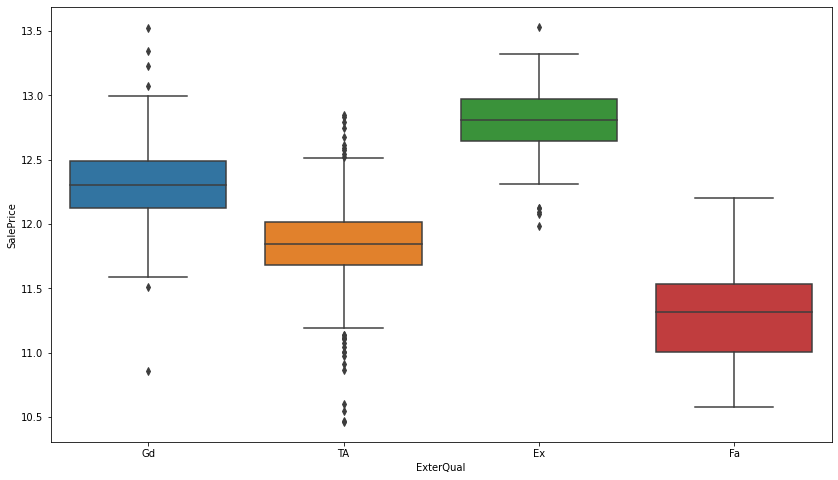

In [77]:
plt.figure(figsize=(14, 8))
sns.boxplot(x = housing['ExterQual'], y= housing['SalePrice'])

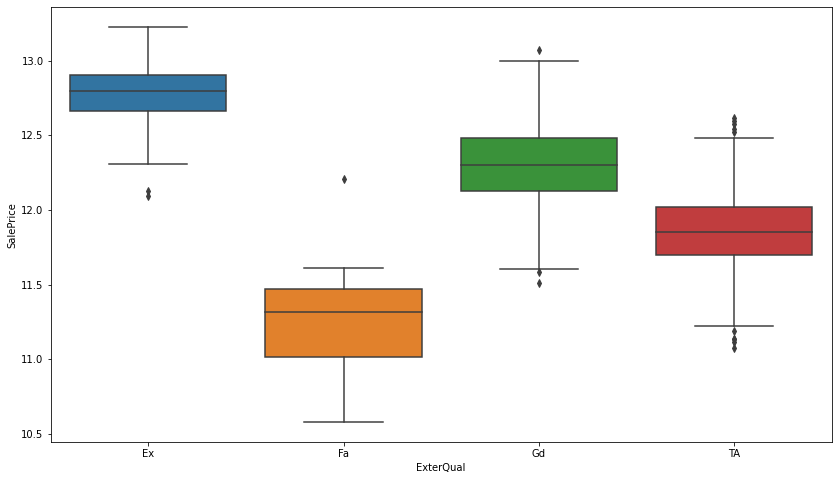

In [78]:
plt.figure(figsize=(14, 8))
sns.boxplot(x = new_data_2['ExterQual'], y= new_data_2['SalePrice'])

In [8]:
y = housing['SalePrice']

In [9]:
housing = housing.drop('SalePrice', axis=1)

In [10]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [79]:
new_data_2.isnull().sum()[new_data_2.isnull().sum()>0]/len(new_data_2)*100

LotFrontage     17.921147
Alley           93.906810
MasVnrType       0.573477
MasVnrArea       0.573477
BsmtQual         2.652330
BsmtCond         2.652330
BsmtExposure     2.724014
BsmtFinType1     2.652330
BsmtFinType2     2.724014
Electrical       0.071685
FireplaceQu     46.953405
GarageType       4.802867
GarageYrBlt      4.802867
GarageFinish     4.802867
GarageQual       4.802867
GarageCond       4.802867
PoolQC          99.713262
Fence           80.716846
MiscFeature     96.487455
dtype: float64

In [82]:
housing = new_data_2.copy()

In [110]:
y = housing['SalePrice']
housing = housing.drop('SalePrice', axis=1)

In [11]:
housing.isnull().sum()[housing.isnull().sum()>0]/len(housing)*100

LotFrontage     17.739726
Alley           93.767123
MasVnrType       0.547945
MasVnrArea       0.547945
BsmtQual         2.534247
BsmtCond         2.534247
BsmtExposure     2.602740
BsmtFinType1     2.534247
BsmtFinType2     2.602740
Electrical       0.068493
FireplaceQu     47.260274
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
PoolQC          99.520548
Fence           80.753425
MiscFeature     96.301370
dtype: float64

In [83]:
housing.isnull().sum()[housing.isnull().sum()>600]

Alley          1310
FireplaceQu     655
PoolQC         1391
Fence          1126
MiscFeature    1346
dtype: int64

In [84]:
null_features = housing.isnull().sum()[housing.isnull().sum()>600].index

In [85]:
housing.MiscFeature.value_counts()

Shed    44
Gar2     2
Othr     2
TenC     1
Name: MiscFeature, dtype: int64

In [86]:
housing.PoolQC.value_counts()

Fa    2
Ex    1
Gd    1
Name: PoolQC, dtype: int64

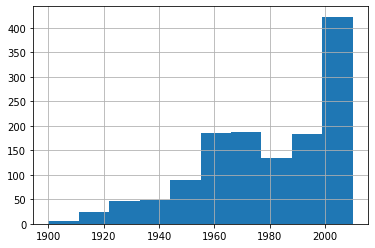

In [87]:
housing['GarageYrBlt'].hist()

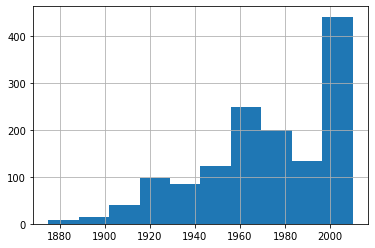

In [88]:
housing['YearBuilt'].hist()

In [89]:
housing['GarageYrBlt'].fillna(housing['YearBuilt'], inplace=True)

In [90]:
housing['GarageAge'] = housing['YrSold'] - housing['GarageYrBlt']

In [91]:
bsmt = []
for i in housing.columns:
    if 'Bsmt' in i:
        bsmt.append(i)

In [92]:
housing[bsmt]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
95,Gd,Gd,No,ALQ,310,Unf,0,370,680,0,0
196,Ex,TA,No,GLQ,1126,Unf,0,600,1726,1,0
412,Ex,TA,Av,GLQ,578,Unf,0,892,1470,1,0
980,TA,TA,Av,ALQ,867,Unf,0,77,944,1,0
1457,TA,Gd,No,GLQ,275,Unf,0,877,1152,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1409,Gd,TA,No,Unf,0,Unf,0,791,791,0,0
1439,TA,TA,No,GLQ,315,Rec,110,114,539,0,0
82,Gd,TA,No,GLQ,33,Unf,0,1530,1563,0,0
458,TA,TA,No,Unf,0,Unf,0,588,588,0,0


In [22]:
housing.BsmtQual.value_counts()

TA    649
Gd    618
Ex    121
Fa     35
Name: BsmtQual, dtype: int64

In [93]:
housing[housing['PoolQC']=='Fa'].SalePrice

810     12.106252
1386    12.429216
Name: SalePrice, dtype: float64

In [94]:
housing.groupby('PoolQC').agg('mean').SalePrice

PoolQC
Ex    12.367341
Fa    12.267734
Gd    12.049419
Name: SalePrice, dtype: float64

In [95]:
housing.Alley.value_counts()

Grvl    46
Pave    39
Name: Alley, dtype: int64

In [96]:
housing.Street.value_counts()

Pave    1391
Grvl       4
Name: Street, dtype: int64

In [97]:
housing[['YearBuilt', 'YearRemodAdd', 'MoSold', 'YrSold']]

,YearBuilt,YearRemodAdd,MoSold,YrSold
95,1993,1993,4,2009
196,2007,2007,9,2007
412,2009,2009,6,2010
980,1961,2007,7,2008
1457,1941,2006,5,2010
...,...,...,...,...
1409,1986,1991,11,2008
1439,1979,1979,11,2007
82,2007,2007,10,2008
458,1925,1996,6,2008


In [98]:
housing = housing.drop(['MiscFeature','PoolQC','Alley', 'Id'],axis=1)

In [150]:
class CombinedAttributesAdder (BaseEstimator, TransformerMixin):
    def __init__ (self):
        return None
    def fit (self, X, y = None):
        return self
    def transform (self, X, y = None):
        X.drop(['MiscFeature','PoolQC','Alley', 'Id'],axis=1)
        X['age'] = X['YrSold'] - X ['YearBuilt']
        X ['Yr_after_remod'] = X['YrSold'] - X ['YearRemodAdd']
        X['GarageYrBlt'].fillna(X['YearBuilt'], inplace=True)
        X['GarageAge'] = X['YrSold'] - X['GarageYrBlt']
        return X

In [111]:
hot_col = []
col = []
for name in housing.columns:
    if housing[name].dtype == 'O' and housing[name].nunique() > 7:
        col.append(name)
    elif housing[name].dtype == 'O' and housing[name].nunique() <= 7:
        hot_col.append(name)

In [ ]:
new_hot_col = []
new_col = []
for name in new_data_2.columns:
    if new_data_2[name].dtype == 'O' and new_data_2[name].nunique() > 7:
        new_col.append(name)
    elif new_data_2[name].dtype == 'O' and new_data_2[name].nunique() <= 7:
        new_hot_col.append(name)

In [112]:
#test
class FinalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, hot_col, col):
        #List of column names in the DataFrame that should be encoded
        self.col = col
        self.hot_col = hot_col
        #Dictionary storing a LabelEncoder for each column
        self.le_dic = {}
        for el in self.col:
            self.le_dic[el] = LabelEncoder()

    def fit(self,X):
        #Fill missing values with the string 'NaN'
        X[self.col] = X[self.col].fillna( -1 )
        for el in self.col:
        #Only use the values that are not 'NaN' to fit the Encoder
            not_nan_values = X[el][X[el]!= -1 ]
            self.le_dic[el].fit(not_nan_values)
        return self

    def transform(self,X,y=None):
        #Fill missing values with the string 'NaN'
        
        for el in self.col:
            #Only use the values that are not 'NaN' to fit the Encoder
            not_nan_values = X[el][X[el]!= -1 ]
            #Store an ndarray of the current column
            column = X[el].to_numpy()
            #Replace the elements in the ndarray that are not 'NaN'
            #using the transformer
            column[column!= -1 ] = self.le_dic[el].transform(not_nan_values)
            #Overwrite the column in the DataFrame
            X[el] = column + 1
            
        Y = X[self.col].copy()
        
        for column in self.hot_col:
            
            s = pd.get_dummies(X[column], prefix = column, dummy_na=True)
            X = pd.concat([X, s], axis=1).drop([column], axis=1)
            
        X = X.drop(self.col, axis = 1)
        
        F = pd.concat([X, Y], axis = 1)
        
        F = F.fillna(0)
        #return the transformed DataFrame
        return F

In [170]:
y2 = np.log(new_data_2.SalePrice)
y2

95      12.128111
412     12.310433
1457    12.493130
238     12.669807
581     12.442302
          ...    
1382    11.964001
1409    12.278393
1439    12.190959
458     11.989160
1244    12.345835
Name: SalePrice, Length: 1359, dtype: float64

In [171]:
new_data_2 = new_data_2.drop('SalePrice',axis = 1)

In [151]:
pipeline = Pipeline([
    ('attribs_adder', CombinedAttributesAdder()),
    ('column_encoder', FinalEncoder(hot_col, col))
])

In [114]:
housing_prepared = pipeline.fit_transform(housing)

In [157]:
housing_prepared

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan,Neighborhood,Condition1,Condition2,HouseStyle,Exterior1st,Exterior2nd,SaleType
95,60,0.0,9765,6,8,1993,1993,68.0,310,0,...,1,0,0,9,3,3,6,13,14,9
196,20,79.0,9416,7,5,2007,2007,205.0,1126,0,...,0,1,0,22,3,3,3,6,6,7
412,20,0.0,4403,7,5,2009,2009,432.0,578,0,...,0,1,0,22,3,3,3,9,9,7
980,85,0.0,12122,7,9,1961,2007,210.0,867,0,...,1,0,0,13,3,3,7,6,6,9
1457,70,66.0,9042,7,9,1941,2006,0.0,275,0,...,1,0,0,7,3,3,6,6,6,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1409,60,46.0,20544,7,6,1986,1991,123.0,0,0,...,1,0,0,15,3,3,6,10,11,9
1439,60,80.0,11584,7,6,1979,1979,96.0,315,110,...,1,0,0,15,3,3,8,7,7,9
82,20,78.0,10206,8,5,2007,2007,468.0,33,0,...,1,0,0,22,3,3,3,13,14,9
458,70,0.0,5100,8,7,1925,1996,0.0,0,0,...,1,0,0,18,3,3,6,12,16,9


In [159]:
housing_prepared.isnull().sum()[housing_prepared.isnull().sum()>0]/len(housing_prepared)*100

Series([], dtype: float64)

In [186]:
n_valid = 460  # same as Kaggle's test set size
n_train = len(new_data_2_prepared) - n_valid
#raw_train, raw_valid = split_vals(final_df, n_train) #for using unprocessed data if needed.
X_train, X_valid = split_vals(new_data_2_prepared, n_train)
y_train, y_valid = split_vals(y2, n_train)

In [116]:
n_valid = 420  # same as Kaggle's test set size
n_train = len(housing_prepared) - n_valid
#raw_train, raw_valid = split_vals(final_df, n_train) #for using unprocessed data if needed.
X_train, X_valid = split_vals(housing_prepared, n_train)
y_train, y_valid = split_vals(y, n_train)

In [117]:
#Run base model
%time
m = RandomForestRegressor(n_estimators=60, min_samples_leaf = 3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=60, n_jobs=-1, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

In [44]:
# 60 estimators with outliers
print_score(m)

RMSE for training:    0.08169888913564387
RMSE for validation:  0.14020658571652278
R^2 for training:     0.9594568365127637
R^2 for validation:   0.8671599155383305
OoB score:            0.8585372420867547


In [118]:
# 60 estimators without outliers
print_score(m)

RMSE for training:    0.06337697794305097
RMSE for validation:  0.1282307386755316
R^2 for training:     0.9759866847837195
R^2 for validation:   0.6584053883559076
OoB score:            0.912816428134821


In [119]:
#after removing outliers
feature_importance = pd.DataFrame({'Feature' : X_train.columns, 'Importance' : m.feature_importances_})
feature_importance.sort_values('Importance', ascending=False, inplace=True)
feature_importance.head(25)

,Feature,Importance
3,OverallQual,0.464598
100,ExterQual_TA,0.094667
15,GrLivArea,0.080195
37,age,0.068504
5,YearBuilt,0.052806
11,TotalBsmtSF,0.039141
26,GarageArea,0.023470
25,GarageCars,0.023427
12,1stFlrSF,0.023153
8,BsmtFinSF1,0.017698


In [122]:
to_keep = feature_importance[feature_importance['Importance'] > 0.0008].Feature.values
len(to_keep)

43

In [123]:
df_keep = housing_prepared[to_keep].copy()

In [124]:
n_valid = 460  # same as Kaggle's test set size
n_train = len(df_keep) - n_valid
#raw_train, raw_valid = split_vals(final_df, n_train) #for using unprocessed data if needed.
X_train, X_valid = split_vals(df_keep, n_train)
y_train, y_valid = split_vals(y, n_train)

In [125]:
#Run base model
m = RandomForestRegressor(n_estimators=60, min_samples_leaf = 3, max_features = 0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=60, n_jobs=-1, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

In [126]:
# 60 estimators without outliers main features, 43 features
print_score(m)

RMSE for training:    0.06557773944615143
RMSE for validation:  0.12673938588154604
R^2 for training:     0.974867965544448
R^2 for validation:   0.6673311648595663
OoB score:            0.9146351361969212


In [128]:
#after removing outliers
feature_importance = pd.DataFrame({'Feature' : X_train.columns, 'Importance' : m.feature_importances_})
feature_importance.sort_values('Importance', ascending=False, inplace=True)
feature_importance.head(25)

,Feature,Importance
0,OverallQual,0.445638
1,ExterQual_TA,0.125315
2,GrLivArea,0.079861
4,YearBuilt,0.068082
3,age,0.050226
6,GarageArea,0.032663
5,TotalBsmtSF,0.032459
8,1stFlrSF,0.025896
7,GarageCars,0.017087
10,LotArea,0.015859


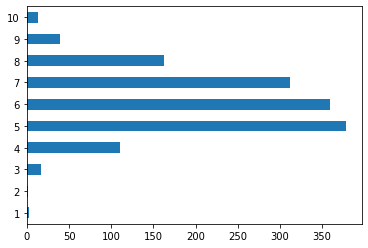

In [127]:
p = df_keep['OverallQual'].value_counts(sort=False).plot.barh()
p

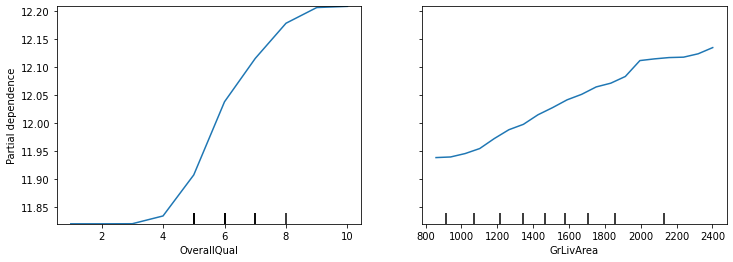

In [130]:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(m, df_keep, ['OverallQual','GrLivArea'],
                        grid_resolution=20, ax=ax);

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [60, 100, 160, 200], 'max_features': [0.2, 0.3, 0.5, 0.7, 0.8], 'min_samples_leaf': [2, 3]},
    # then try 6 (2×3) combinations with bootstrap set as False
    #{'bootstrap': [False], 'n_estimators': [60, 100, 160], 'max_features': [0.3, 0.5, 0.7], 'min_samples_leaf': [2, 3, 5]},
  ]

# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(m, param_grid, cv = 5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

%time
grid_search.fit(X_train, y_train)

In [54]:
from sklearn.model_selection import cross_val_score

In [55]:
scores = cross_val_score (m, X_valid, y_valid,
                         scoring = "neg_mean_squared_error", cv = 5)

rmse_scores = np.sqrt(-scores)

In [56]:
def display_scores(scores):
    print("Scores", scores)
    print("Mean", scores.mean())
    print ("St.d", scores.std())

In [57]:
# 60 estimators with outliers main features, 58 features
display_scores(rmse_scores)

Scores [0.14963565 0.16890568 0.12074456 0.19980392 0.1362061 ]
Mean 0.15505918386152953
St.d 0.02740862542560377


In [210]:
# 60 estimators without outliers main features, 44 features
display_scores(rmse_scores)

Scores [0.12721512 0.0965186  0.12979954 0.16284722 0.09529868 0.10290008
 0.13107008 0.09045612 0.1209124  0.1135051 ]
Mean 0.11705229323064285
St.d 0.02095095712495013


In [232]:
# 60 estimators without outliers main features, 37 features
display_scores(rmse_scores)

Scores [0.13374334 0.10833144 0.137275   0.16143723 0.09081041 0.1080191
 0.12832467 0.08958352 0.11626148 0.11812787]
Mean 0.11919140667778245
St.d 0.02083622818779423


In [245]:
# 60 estimators without outliers main features, 109 features
display_scores(rmse_scores)

Scores [0.14134073 0.10680867 0.13235999 0.15759859 0.08857465 0.1013224
 0.12352459 0.10209071 0.12135715 0.10442521]
Mean 0.11794027011411386
St.d 0.020167852547846872


In [134]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [60, 100, 160, 200], 'max_features': [0.2, 0.3, 0.5, 0.7, 0.8], 'min_samples_leaf': [2, 3]},
    # then try 6 (2×3) combinations with bootstrap set as False
    #{'bootstrap': [False], 'n_estimators': [60, 100, 160], 'max_features': [0.3, 0.5, 0.7], 'min_samples_leaf': [2, 3, 5]},
  ]

# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(m, param_grid, cv = 5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

%time
grid_search.fit(X_train, y_train)

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 12.2 µs


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features=0.5,
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=3,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=60, n_jobs=-1,
                                             oob_score=True, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs=None

In [135]:
#57 features
grid_search.best_params_

{'max_features': 0.2, 'min_samples_leaf': 3, 'n_estimators': 100}

In [136]:
#Run base model
m = RandomForestRegressor(n_estimators=100, min_samples_leaf = 2, max_features = 0.2, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.2, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

In [137]:
# 100 estimators without outliers main 57 features
print_score(m)

RMSE for training:    0.06019425827594128
RMSE for validation:  0.13230971167706945
R^2 for training:     0.9788249279146046
R^2 for validation:   0.637446279020736
OoB score:            0.9128871077848306


In [152]:
test = pd.read_csv('test.csv')

In [153]:
hot_col = []
col = []
for name in test.columns:
    if test[name].dtype == 'O' and test[name].nunique() > 7:
        col.append(name)
    elif test[name].dtype == 'O' and test[name].nunique() <= 7:
        hot_col.append(name)

In [154]:
test_prepared = pipeline.fit_transform(test)

In [160]:
test_prepared.isnull().sum()[test_prepared.isnull().sum()>0]/len(test_prepared)*100

Series([], dtype: float64)

In [170]:
final_test = test_prepared[to_keep]

In [176]:
test_predictions = m.predict(final_test)

In [177]:
test_predictions

array([11.73186721, 11.91233317, 12.0543208 , ..., 11.94526138,
       11.72067514, 12.31250917])

In [178]:
result = np.exp(test_predictions)

In [179]:
result

array([124475.87589454, 149094.13610599, 171840.29319549, ...,
       154085.26196527, 123090.50070761, 222461.46439328])

In [180]:
len(result)

1459

In [198]:
ids = np.arange(1461,2920)

In [199]:
len(ids)

1459

In [200]:
d = {'Id': ids, 'SalePrice': result}

In [201]:
submission = pd.DataFrame(data = d)

In [202]:
submission

,Id,SalePrice
0,1461,124475.875895
1,1462,149094.136106
2,1463,171840.293195
3,1464,180019.970586
4,1465,191619.773109
...,...,...
1454,2915,86828.659814
1455,2916,88564.429129
1456,2917,154085.261965
1457,2918,123090.500708


In [205]:
results = submission.to_csv(r'Desktop\⁨PYTHON⁩⁨\⁨⁨TensorFlow_FILES⁩\⁨DATA⁩\⁨submission.csv',index=False, header = True)

Text(0, 0.5, 'Predicted')

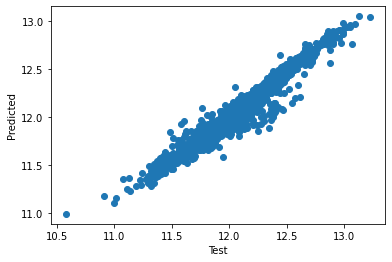

In [141]:
housing_predictions = m.predict(df_keep)

plt.scatter(y, housing_predictions)
plt.xlabel('Test')
plt.ylabel('Predicted')

In [60]:
#Run base model
m = RandomForestRegressor(n_estimators=100, min_samples_leaf = 2, max_features = 0.3, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

In [61]:
# 100 estimators without outliers main 57 features
print_score(m)

RMSE for training:    0.0701717783618283
RMSE for validation:  0.13749273108070204
R^2 for training:     0.9700904212977937
R^2 for validation:   0.872252681383767
OoB score:            0.869587720347544


In [248]:
#Run final model 109 features
final_m = RandomForestRegressor(n_estimators = 160, min_samples_leaf = 2, max_features = 0.7, n_jobs=-1, oob_score=True)
final_m.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.7, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=160, n_jobs=-1, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

In [249]:
# 60 estimators without outliers main 109 features
print_score(final_m)

RMSE for training:    0.053665456662697474
RMSE for validation:  0.13918297391118273
R^2 for training:     0.981565046349841
R^2 for validation:   0.5611595303613969
OoB score:            0.9055633958289373


In [220]:
# 60 estimators without outliers main 44 features
print_score(final_m)

RMSE for training:    0.058147293226414334
RMSE for validation:  0.11902116932355733
R^2 for training:     0.9783573020991151
R^2 for validation:   0.6790902790151303
OoB score:            0.9025687038017316


In [235]:
# 60 estimators without outliers main 37 features
print_score(final_m)

RMSE for training:    0.059523416528239205
RMSE for validation:  0.1220760219998742
R^2 for training:     0.9773207810804163
R^2 for validation:   0.662405637902883
OoB score:            0.901814021816255


In [221]:
scores = cross_val_score (final_m, X_valid, y_valid,
                         scoring = "neg_mean_squared_error", cv = 10)

rmse_scores = np.sqrt(-scores)

display_scores(rmse_scores)

Scores [0.13567773 0.10539982 0.13297681 0.16110864 0.08562809 0.10669865
 0.13198575 0.09477717 0.12178771 0.10859628]
Mean 0.11846366471625644
St.d 0.02136612988085902


Text(0, 0.5, 'Predicted')

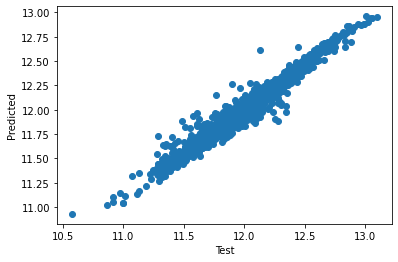

In [222]:

housing_predictions = final_m.predict(df_keep)

plt.scatter(y2, housing_predictions)
plt.xlabel('Test')
plt.ylabel('Predicted')

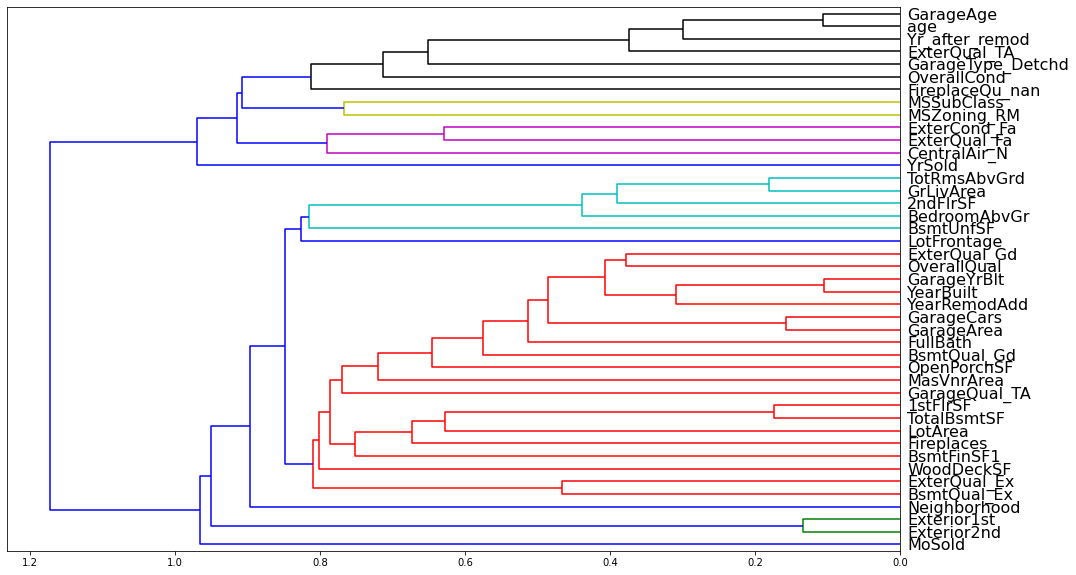

In [131]:
import scipy
from scipy.cluster import hierarchy as hc

corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [57]:
feature_importance = pd.DataFrame({'Feature' : X_train.columns, 'Importance' : m.feature_importances_})
feature_importance.sort_values('Importance', ascending=False, inplace=True)
feature_importance.head(25)

,Feature,Importance
3,OverallQual,0.332021
15,GrLivArea,0.163830
5,YearBuilt,0.046899
36,age,0.043435
91,ExterQual_TA,0.040111
11,TotalBsmtSF,0.039958
26,GarageArea,0.039394
25,GarageCars,0.037570
12,1stFlrSF,0.029248
18,FullBath,0.023328


In [59]:
to_keep = feature_importance[feature_importance['Importance'] > 0.001].Feature.values
len(to_keep)

52

In [60]:
df_keep = housing_prepared[to_keep].copy()

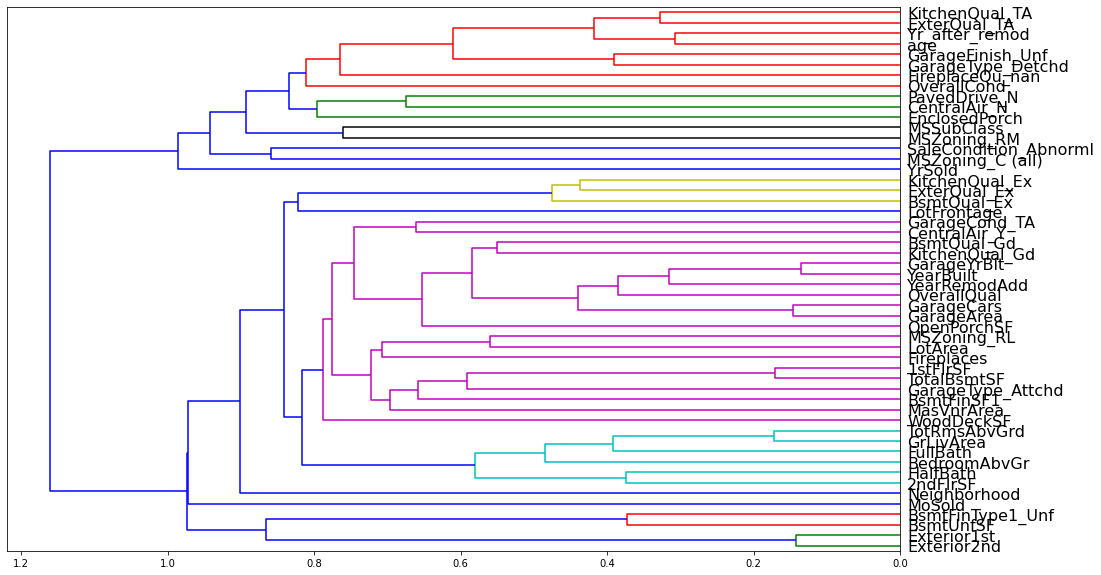

In [61]:
import scipy
from scipy.cluster import hierarchy as hc

corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [62]:
df = housing_prepared[to_keep].copy()

In [63]:
df['price'] = y

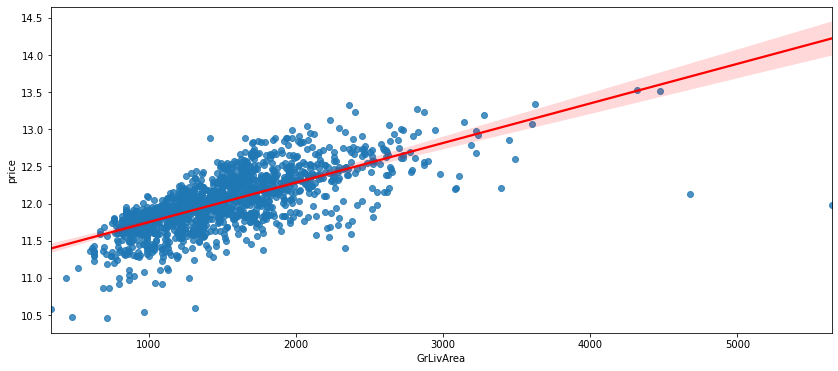

In [76]:
plt.figure(figsize=(14, 6))

sns.regplot(x = df['GrLivArea'], y= df['price'], line_kws={'color': 'r'})

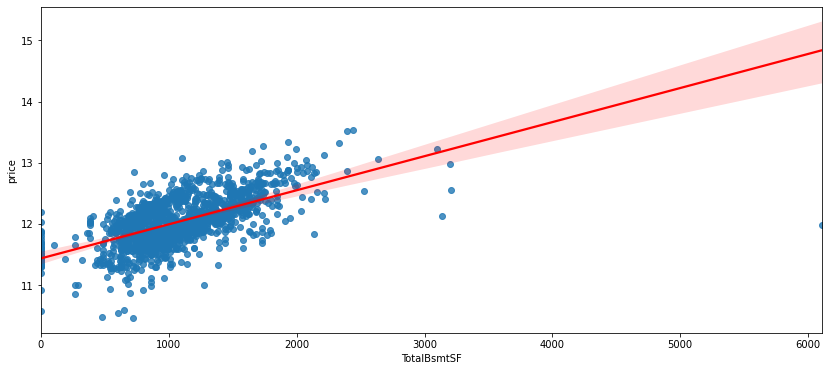

In [261]:

plt.figure(figsize=(14, 6))

sns.regplot(x = df['TotalBsmtSF'], y= df['price'], line_kws={'color': 'r'})

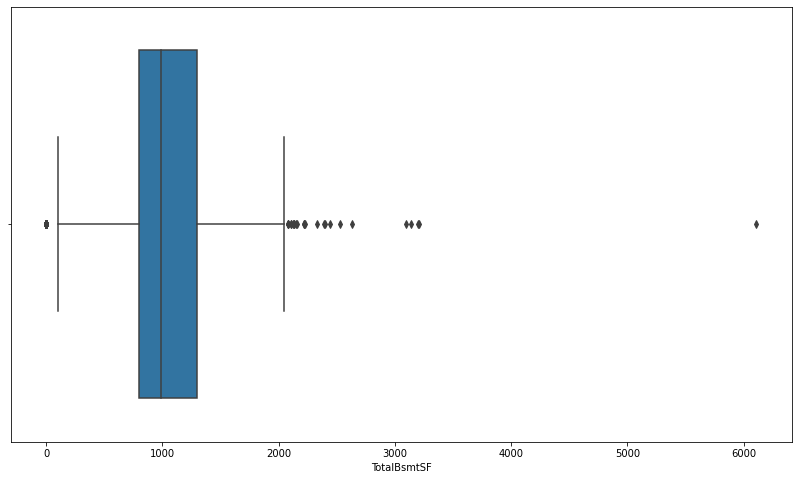

In [263]:
plt.figure(figsize=(14, 8))
sns.boxplot(df['TotalBsmtSF'])

In [277]:
df[df['TotalBsmtSF']>5000]

,OverallQual,GrLivArea,YearBuilt,age,ExterQual_TA,TotalBsmtSF,GarageArea,GarageCars,1stFlrSF,FullBath,...,GarageCond_TA,YrSold,GarageFinish_Unf,BsmtQual_Ex,PavedDrive_N,BsmtFinType1_Unf,EnclosedPorch,HalfBath,KitchenQual_Ex,price
1298,10,5642,2008,0,0,6110,1418,2,4692,2,...,1,2008,0,1,0,0,0,1,1,11.982929


In [295]:
best_overall_qual = housing[housing.OverallQual == 10]

In [300]:
best_overall_qual

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
58,59,60,RL,66.0,13682,Pave,NaN,IR2,HLS,AllPub,...,0,NaN,NaN,NaN,0,10,2006,New,Partial,438780
185,186,75,RM,90.0,22950,Pave,NaN,IR2,Lvl,AllPub,...,0,NaN,GdPrv,NaN,0,6,2006,WD,Normal,475000
224,225,20,RL,103.0,13472,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,386250
389,390,60,RL,96.0,12474,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2008,New,Partial,426000
440,441,20,RL,105.0,15431,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,555000
515,516,20,RL,94.0,12220,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2009,New,Partial,402861
523,524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
583,584,75,RM,75.0,13500,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2008,WD,Normal,325000
591,592,60,RL,97.0,13478,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2009,ConLI,Normal,451950
691,692,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,755000


In [293]:
housing[housing['TotalBsmtSF']>5000].Fireplaces

1298    3
Name: Fireplaces, dtype: int64

In [301]:
housing.LandContour.value_counts()

Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64

In [306]:
bnk = housing[housing.LandContour == 'Bnk']

In [315]:
bnk['ExterQual'].value_counts()

TA    53
Fa     5
Gd     3
Ex     2
Name: ExterQual, dtype: int64

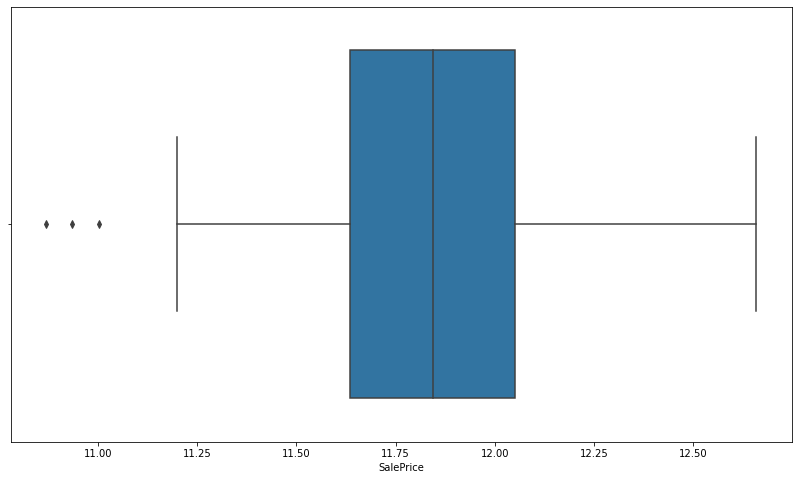

In [310]:
plt.figure(figsize=(14, 8))
sns.boxplot(np.log(bnk['SalePrice']))

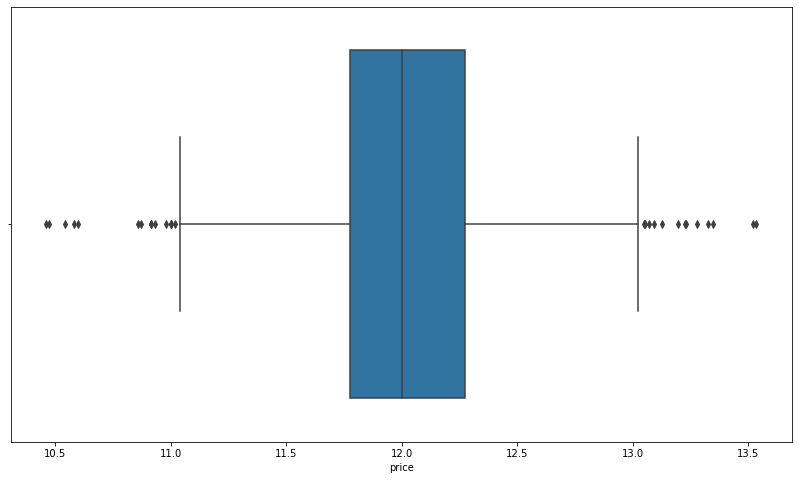

In [279]:
plt.figure(figsize=(14, 8))
sns.boxplot(df['price'])

In [281]:
df['price'].median()

12.0015054797889

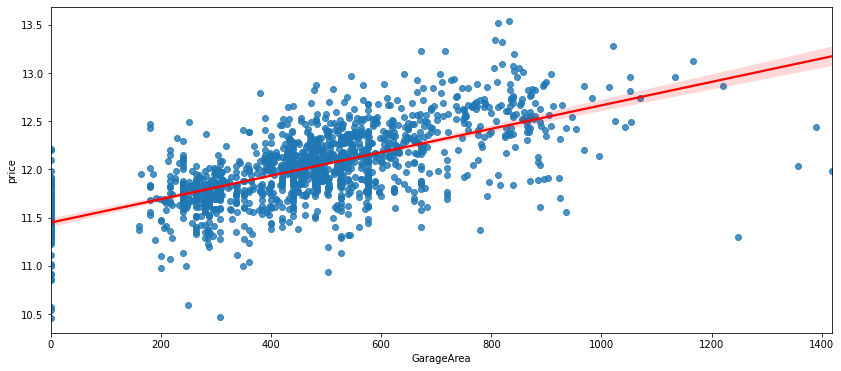

In [79]:
plt.figure(figsize=(14, 6))

sns.regplot(x = df['GarageArea'], y= df['price'], line_kws={'color': 'r'})

In [64]:
ix = df.corr().price.sort_values(ascending=False)[:12].index
ib = df.corr().price.sort_values(ascending=True)[:6].index

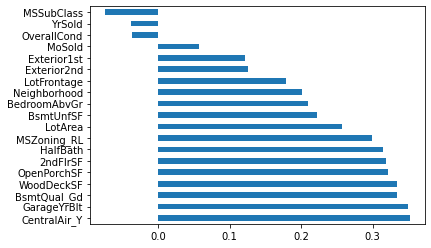

In [304]:
df.corr().price.sort_values(ascending=False)[20:39].plot( kind = 'barh')

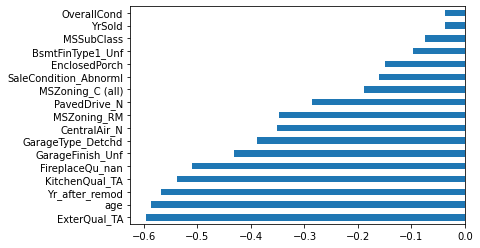

In [292]:
df.corr().price.sort_values(ascending=True)[:17].plot( kind = 'barh')

In [45]:
housing.ExterQual.value_counts()

TA    906
Gd    488
Ex     52
Fa     14
Name: ExterQual, dtype: int64

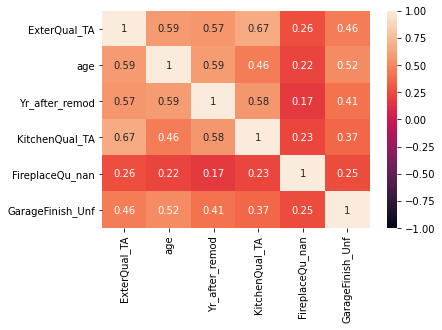

In [70]:
sns.heatmap(df[ib].corr(), vmin=-1, vmax=1, annot=True)

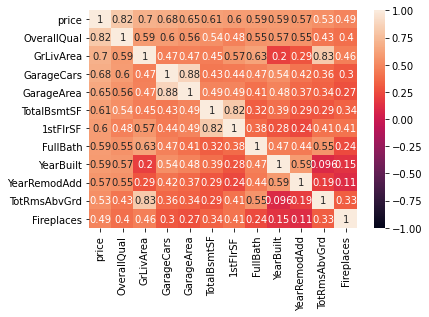

In [71]:
sns.heatmap(df[ix].corr(), vmin=-1, vmax=1, annot=True)

In [125]:
garage = housing[['GarageArea', 'GarageCars', 'GarageQual', 'GarageCond', 'GarageFinish', 'GarageType']]

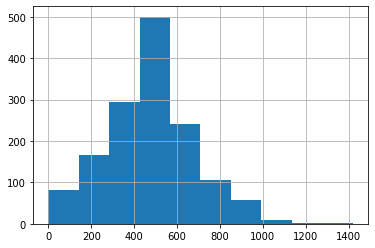

In [136]:
garage.GarageArea.hist()

In [93]:
housing.GarageCars.value_counts()

2    824
1    369
3    181
0     81
4      5
Name: GarageCars, dtype: int64

In [138]:
housing.OverallQual.value_counts()

5     397
6     374
7     319
8     168
4     116
9      43
3      20
10     18
2       3
1       2
Name: OverallQual, dtype: int64

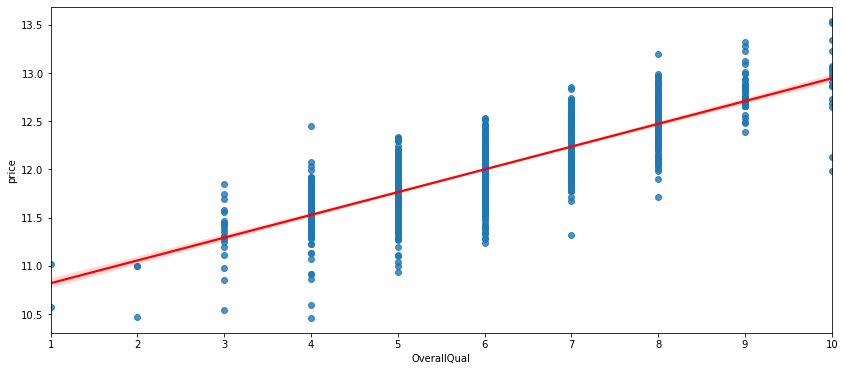

In [139]:
plt.figure(figsize=(14, 6))

sns.regplot(x = df['OverallQual'], y= df['price'], line_kws={'color': 'r'})

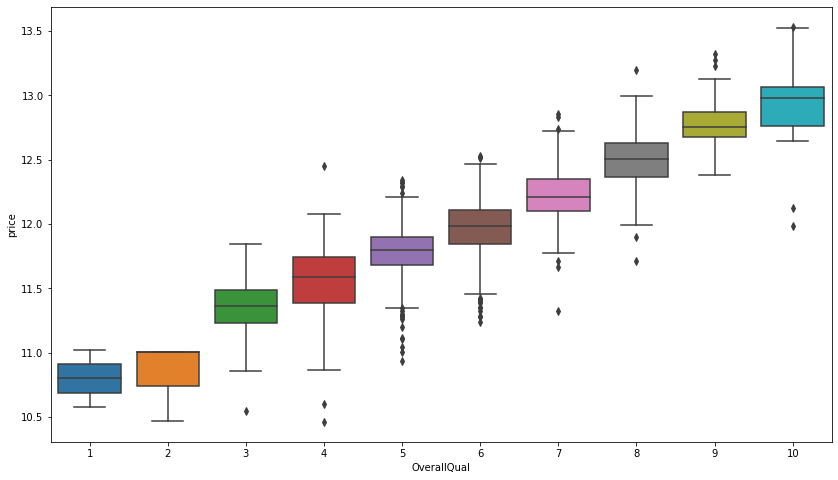

In [140]:
plt.figure(figsize=(14, 8))
sns.boxplot(x = df['OverallQual'], y= df['price'])

In [ ]:
ExterQual

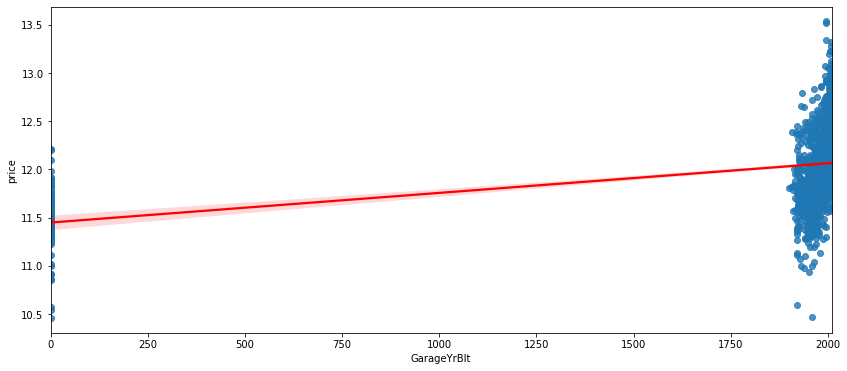

In [96]:
plt.figure(figsize=(14, 6))

sns.regplot(x = df['GarageYrBlt'], y= df['price'], line_kws={'color': 'r'})

In [ ]:
GarageType: Garage location
GarageYrBlt: Year garage was built
GarageFinish: Interior finish of the garage
GarageCars: Size of garage in car capacity
GarageArea: Size of garage in square feet
GarageQual: Garage quality
GarageCond: Garage condition

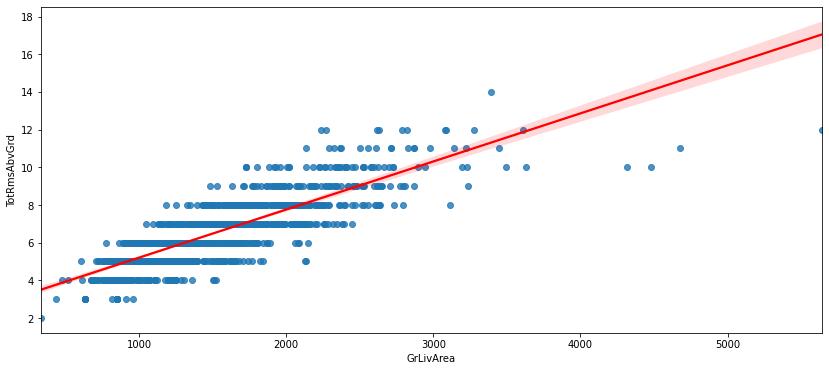

In [80]:
plt.figure(figsize=(14, 6))

sns.regplot(x = df['GrLivArea'], y= df['TotRmsAbvGrd'], line_kws={'color': 'r'})

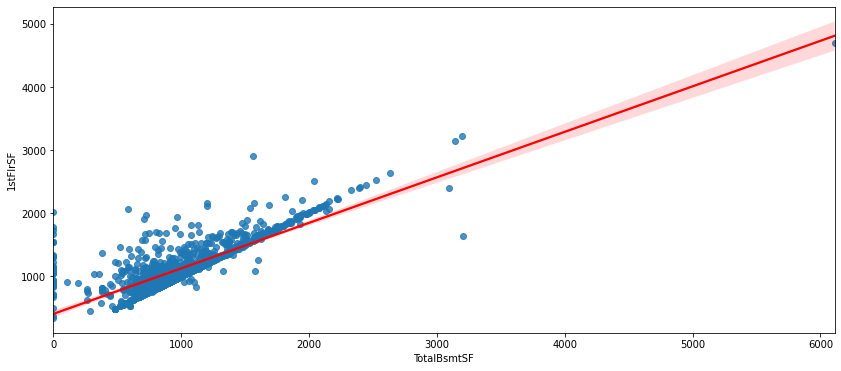

In [83]:
plt.figure(figsize=(14, 6))

sns.regplot(x = df['TotalBsmtSF'], y= df['1stFlrSF'], line_kws={'color': 'r'})

In [85]:
housing.Foundation.value_counts()

PConc     647
CBlock    634
BrkTil    146
Slab       24
Stone       6
Wood        3
Name: Foundation, dtype: int64

In [86]:
housing.Electrical.value_counts()

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [49]:
df['FullBath'].value_counts()

2    768
1    650
3     33
0      9
Name: FullBath, dtype: int64

In [72]:
df_keep.columns

Index(['OverallQual', 'GrLivArea', 'YearBuilt', 'age', 'ExterQual_TA',
       'TotalBsmtSF', 'GarageArea', 'GarageCars', '1stFlrSF', 'FullBath',
       'BsmtFinSF1', 'LotArea', 'GarageYrBlt', 'Yr_after_remod',
       'YearRemodAdd', '2ndFlrSF', 'OverallCond', 'Neighborhood', 'Fireplaces',
       'FireplaceQu_nan', 'CentralAir_Y', 'CentralAir_N', 'BsmtUnfSF',
       'OpenPorchSF', 'LotFrontage', 'TotRmsAbvGrd', 'GarageType_Attchd',
       'MasVnrArea', 'BedroomAbvGr', 'MoSold', 'GarageType_Detchd',
       'MSZoning_RM', 'KitchenQual_Gd', 'MSZoning_C (all)', 'Exterior2nd',
       'KitchenQual_TA', 'MSSubClass', 'MSZoning_RL', 'WoodDeckSF',
       'Exterior1st', 'SaleCondition_Abnorml', 'BsmtQual_Gd', 'ExterQual_Ex',
       'GarageCond_TA', 'YrSold', 'GarageFinish_Unf', 'BsmtQual_Ex',
       'PavedDrive_N', 'BsmtFinType1_Unf', 'EnclosedPorch', 'HalfBath',
       'KitchenQual_Ex'],
      dtype='object')

In [74]:
df['TotRmsAbvGrd'].value_counts()

6     402
7     329
5     275
8     187
4      97
9      75
10     47
11     18
3      17
12     11
14      1
2       1
Name: TotRmsAbvGrd, dtype: int64

In [302]:
df['GrArea_no_Bsmt'] = df['GrLivArea'] - df['TotalBsmtSF']

/anaconda3/envs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [132]:
df_keep.corr().price.sort_values(ascending=False)

AttributeError: 'DataFrame' object has no attribute 'price'

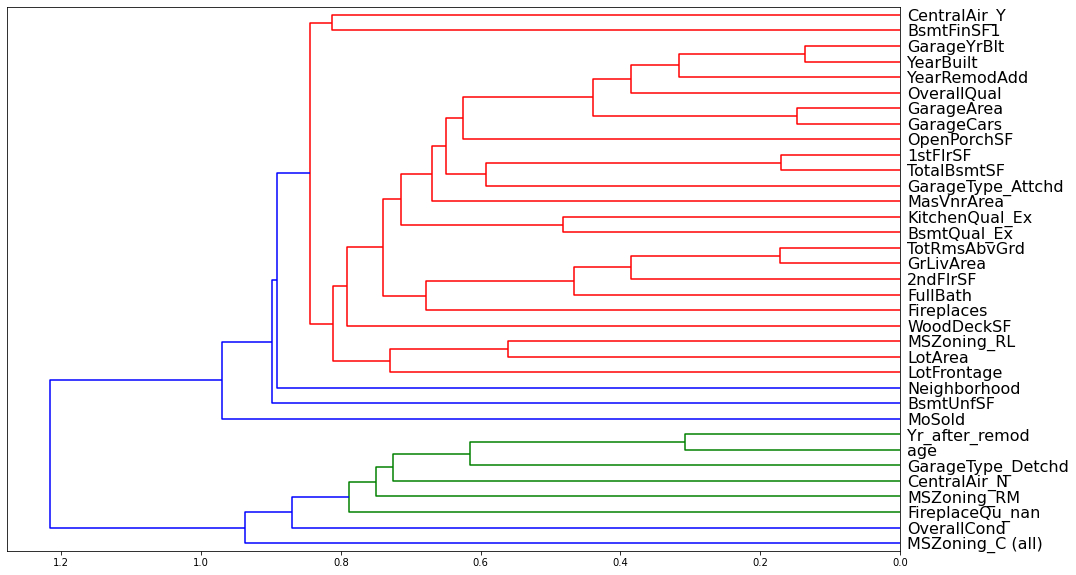

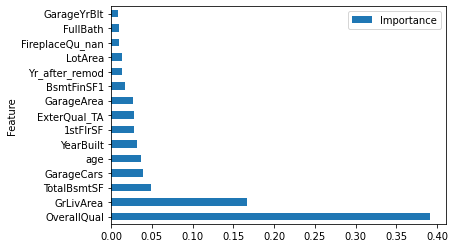

In [215]:
feature_importance[:15].plot('Feature', 'Importance', kind = 'barh')

In [226]:
X_train, X_valid = split_vals(df_keep, n_train)

#Run base model
m = RandomForestRegressor(n_estimators=160, min_samples_leaf = 3, max_features = 0.3, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=160, n_jobs=-1, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

In [227]:
%%time
print_score(m)

RMSE for training:    0.08127428635996886
RMSE for validation:  0.13868803419160297
R^2 for training:     0.9600775115335289
R^2 for validation:   0.8657854690630843
OoB score:            0.8736592516895951
CPU times: user 252 ms, sys: 45.5 ms, total: 297 ms
Wall time: 436 ms


In [220]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [60, 100, 150], 'max_features': [0.3, 0.5, 0.7], 'min_samples_leaf': [3, 5, 7]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [60, 100, 150], 'max_features': [0.3, 0.5, 0.7], 'min_samples_leaf': [3, 5, 7]},
  ]

forest_reg = RandomForestRegressor(random_state=42, n_jobs=-1)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

%time
grid_search.fit(X_train, y_train)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.87 µs


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             oob_score=False, random...
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs=None,
  

In [221]:
grid_search.best_params_

{'bootstrap': False,
 'max_features': 0.3,
 'min_samples_leaf': 3,
 'n_estimators': 100}

In [222]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.14777081994862917 {'max_features': 0.3, 'min_samples_leaf': 3, 'n_estimators': 60}
0.14615220983674818 {'max_features': 0.3, 'min_samples_leaf': 3, 'n_estimators': 100}
0.14571024099602764 {'max_features': 0.3, 'min_samples_leaf': 3, 'n_estimators': 150}
0.15058800617272067 {'max_features': 0.3, 'min_samples_leaf': 5, 'n_estimators': 60}
0.15011652379638094 {'max_features': 0.3, 'min_samples_leaf': 5, 'n_estimators': 100}
0.14979715767107818 {'max_features': 0.3, 'min_samples_leaf': 5, 'n_estimators': 150}
0.1520476914707964 {'max_features': 0.3, 'min_samples_leaf': 7, 'n_estimators': 60}
0.15209333623500845 {'max_features': 0.3, 'min_samples_leaf': 7, 'n_estimators': 100}
0.15203201782880632 {'max_features': 0.3, 'min_samples_leaf': 7, 'n_estimators': 150}
0.14708897017871633 {'max_features': 0.5, 'min_samples_leaf': 3, 'n_estimators': 60}
0.1455526969176853 {'max_features': 0.5, 'min_samples_leaf': 3, 'n_estimators': 100}
0.1450193779140182 {'max_features': 0.5, 'min_samples_leaf':

In [151]:
model_scores = pd.DataFrame(columns = ['Score', 'Params'])

In [157]:
model_scores

,Score,Params


In [13]:
housing[null_features]

,Alley,FireplaceQu,PoolQC,Fence,MiscFeature
0,NaN,NaN,NaN,NaN,NaN
1,NaN,TA,NaN,NaN,NaN
2,NaN,TA,NaN,NaN,NaN
3,NaN,Gd,NaN,NaN,NaN
4,NaN,TA,NaN,NaN,NaN
...,...,...,...,...,...
1455,NaN,TA,NaN,NaN,NaN
1456,NaN,TA,NaN,MnPrv,NaN
1457,NaN,Gd,NaN,GdPrv,Shed
1458,NaN,NaN,NaN,NaN,NaN


In [11]:
housing.LotFrontage.value_counts()

60.0     143
70.0      70
80.0      69
50.0      57
75.0      53
        ... 
106.0      1
38.0       1
138.0      1
140.0      1
137.0      1
Name: LotFrontage, Length: 110, dtype: int64

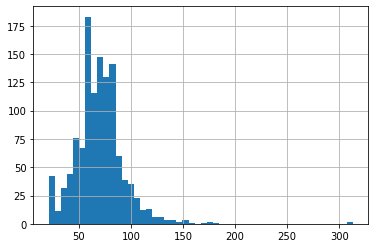

In [12]:
housing.LotFrontage.hist(bins=50)

In [8]:
housing.isnull().sum()[21:40]

RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       8
MasVnrArea       8
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual        37
BsmtCond        37
BsmtExposure    38
BsmtFinType1    37
BsmtFinSF1       0
BsmtFinType2    38
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
Heating          0
dtype: int64

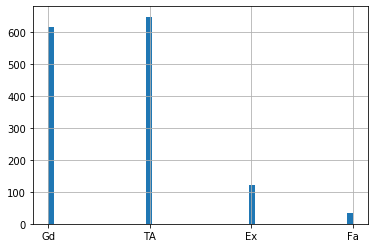

In [13]:
housing.BsmtQual.hist(bins=50)

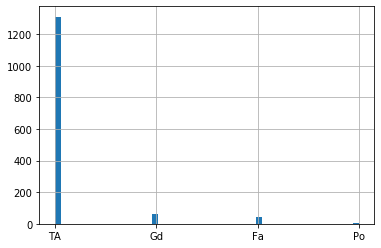

In [14]:
housing.BsmtCond.hist(bins=50)

In [9]:
housing.isnull().sum()[41:60]

CentralAir        0
Electrical        1
1stFlrSF          0
2ndFlrSF          0
LowQualFinSF      0
GrLivArea         0
BsmtFullBath      0
BsmtHalfBath      0
FullBath          0
HalfBath          0
BedroomAbvGr      0
KitchenAbvGr      0
KitchenQual       0
TotRmsAbvGrd      0
Functional        0
Fireplaces        0
FireplaceQu     690
GarageType       81
GarageYrBlt      81
dtype: int64

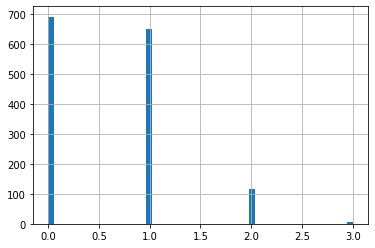

In [16]:
housing.Fireplaces.hist(bins=50)

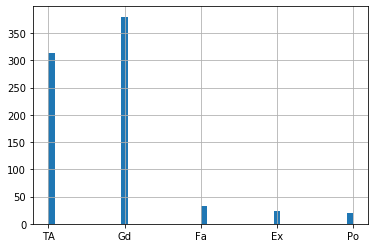

In [15]:
housing.FireplaceQu.hist(bins=50)

In [10]:
housing.isnull().sum()[61:]

GarageCars          0
GarageArea          0
GarageQual         81
GarageCond         81
PavedDrive          0
WoodDeckSF          0
OpenPorchSF         0
EnclosedPorch       0
3SsnPorch           0
ScreenPorch         0
PoolArea            0
PoolQC           1453
Fence            1179
MiscFeature      1406
MiscVal             0
MoSold              0
YrSold              0
SaleType            0
SaleCondition       0
SalePrice           0
dtype: int64

In [42]:
housing.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [43]:
basement = []
for i in housing.columns:
    if 'Bsmt' in i:
        basement.append(i)

In [80]:
garage = []
for i in housing.columns:
    if 'Garage' in i:
        garage.append(i)

In [81]:
garage

['GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond']

In [44]:
basement

['BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'BsmtFullBath',
 'BsmtHalfBath']

In [47]:
print(*basement, sep=", ")

BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath, BsmtHalfBath


In [60]:
saleprice = housing['SalePrice']

In [61]:
base = housing[basement]
base['Price'] = saleprice

/anaconda3/envs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [82]:
gar = housing[garage]
gar['Price'] = saleprice

/anaconda3/envs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [66]:
base.isnull().sum()

BsmtQual        37
BsmtCond        37
BsmtExposure    38
BsmtFinType1    37
BsmtFinSF1       0
BsmtFinType2    38
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
BsmtFullBath     0
BsmtHalfBath     0
Price            0
dtype: int64

In [84]:
gar.isnull().sum()

GarageType      81
GarageYrBlt     81
GarageFinish    81
GarageCars       0
GarageArea       0
GarageQual      81
GarageCond      81
Price            0
dtype: int64

In [85]:
gar.dropna(inplace=True)

/anaconda3/envs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [70]:
base.dropna(inplace=True)

/anaconda3/envs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [75]:
base

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,Price
0,Gd,TA,No,GLQ,706,Unf,0,150,856,1,0,208500
1,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,0,1,181500
2,Gd,TA,Mn,GLQ,486,Unf,0,434,920,1,0,223500
3,TA,Gd,No,ALQ,216,Unf,0,540,756,1,0,140000
4,Gd,TA,Av,GLQ,655,Unf,0,490,1145,1,0,250000
...,...,...,...,...,...,...,...,...,...,...,...,...
1455,Gd,TA,No,Unf,0,Unf,0,953,953,0,0,175000
1456,Gd,TA,No,ALQ,790,Rec,163,589,1542,1,0,210000
1457,TA,Gd,No,GLQ,275,Unf,0,877,1152,0,0,266500
1458,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,1,0,142125


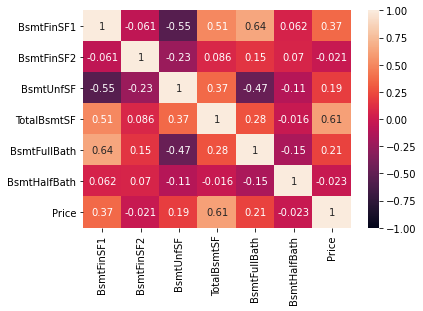

In [79]:
sns.heatmap(base.corr(), vmin=-1, vmax=1, annot=True)

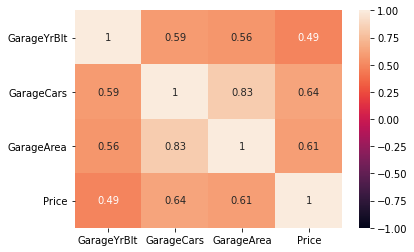

In [86]:
sns.heatmap(gar.corr(), vmin=-1, vmax=1, annot=True)

In [6]:
housing[['YearBuilt','YearRemodAdd','GarageYrBlt','MoSold','YrSold',"MSSubClass"]]

,YearBuilt,YearRemodAdd,GarageYrBlt,MoSold,YrSold,MSSubClass
0,2003,2003,2003.0,2,2008,60
1,1976,1976,1976.0,5,2007,20
2,2001,2002,2001.0,9,2008,60
3,1915,1970,1998.0,2,2006,70
4,2000,2000,2000.0,12,2008,60
...,...,...,...,...,...,...
1455,1999,2000,1999.0,8,2007,60
1456,1978,1988,1978.0,2,2010,20
1457,1941,2006,1941.0,5,2010,70
1458,1950,1996,1950.0,4,2010,20
